# Experiments LSTM net

Here we tried to replicate the network that was used in [this](https://www.nature.com/articles/s41598-018-33321-1#Sec2) paper. But instead of using GRU we used LSTM. 

In [1]:
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from itertools import product
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
genomes = pd.read_csv('data/Input_file.txt', sep=';', header=None)
genomes.columns = ['id', 'sequence', 'coding_regions', 'labels', 'type']

In [3]:
print(len(genomes.loc[0, 'sequence']))
print(len(genomes.loc[0, 'labels']))

159624
159624


In [4]:
from statistics import mode 
def chooseLabel(labels, scheme='majority'):
    if scheme == 'majority':
        return mode(labels)

In [5]:
def getDesignSet(sequence, labels, window_size, stride, sequence_length_threshold):

    out_set = []

    if stride > window_size:
        print('ERROR! stride is larger than window size')

    if len(sequence) != len(labels):
        print('ERROR! sequence and labels lengths dont match')

    words_dataset = (len(sequence) - (window_size - stride))/ stride
    print('Words in dataset: ' + str(words_dataset))

    position = 0
    while position < len(sequence) - 1:

        if (len(sequence) - 1) - position < sequence_length_threshold:
            print('Too short to add, position: ' + str(position))
            break

        sub_sequence = []
        sub_labels = []
        for i in range(0, sequence_length_threshold, stride):
            temp_seq = []
            temp_lab = []
            for j in range(window_size):
                temp_seq.append(sequence[position + j])
                temp_lab.append(int(labels[position + j]))
            sub_sequence.append(''.join(temp_seq))
            sub_labels.append(chooseLabel(temp_lab, scheme='majority'))
            position += stride

        out_set.append((sub_sequence, sub_labels))
    
    print(len(out_set))
        
    return out_set

In [8]:
window_size = 5
stride = 2
sequence_length_threshold = 100
genomes_to_load = 10

raw_sequence = ''
raw_labels = ''
for i in range(0, genomes.shape[0] if genomes.shape[0] < genomes_to_load else genomes_to_load):
    raw_sequence = raw_sequence + genomes.loc[i, 'sequence']
    raw_labels = raw_labels + genomes.loc[i, 'labels']
    
# clean
sequence = []
labels = []
for i in range(len(raw_sequence)):
    if raw_sequence[i] in 'AGCT':
        sequence.append(raw_sequence[i])
        labels.append(raw_labels[i])

print('nucleotides in dataset: ' + str(len(sequence)))

design_set = getDesignSet(sequence, labels, window_size, stride, sequence_length_threshold)
print('Size design set: ' + str(len(design_set)))

nucleotides in dataset: 1160796
Words in dataset: 580396.5
Too short to add, position: 1160700
11607
Size design set: 11607


## Data preparation

In [9]:
letters = 'AGCT'
vocab = [''.join(i) for i in product(letters, repeat = window_size)]
kmers_dict = {}
for i in range(len(vocab)):
  kmers_dict[vocab[i]] = i
len(kmers_dict)

1024

In [10]:
def prepareSequence(sequence, lookup_table):
    return torch.tensor([lookup_table[i] for i in sequence], dtype=torch.torch.long)

## LSTM

In [11]:
class BasicLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_dim, labset_dim, bidirectional):
        super(BasicLSTM, self).__init__()
        
        hidden_dim_dense = hidden_dim
        if bidirectional:
            hidden_dim_dense = hidden_dim * 2
        
        self.kmer2embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_dim,bidirectional=bidirectional)
        self.dense = nn.Linear(hidden_dim_dense, labset_dim)        

#     kmer_embedding = self.kmer_embedder(sequence)
#     out, _ = self.left2RightLSTM(kmer_embedding.view(len(sequence), 1, -1))
#     transformed_out = self.hidden2lab(out.view(len(sequence), -1))
#     labels_score = F.log_softmax(transformed_out, dim=1)
#     return labels_score

    def forward(self, sequence):
#         print("Input")
#         print(sequence.shape)
#         print(sequence)
        embedded_kmers = self.kmer2embedding(sequence)
#         print("Embedded kmers")
#         print(embedded_kmers.shape)
#         print(embedded_kmers)
#         print("Embedded kmers reshaped")
#         print(embedded_kmers.view(len(sequence), 1, -1).shape)
#         print(embedded_kmers.view(len(sequence), 1, -1))
        out_lstm, _ = self.lstm(embedded_kmers.view(len(sequence), 1, -1))
#         print("out lstm")
#         print(out_lstm.view(len(sequence), -1).shape)
#         print(out_lstm.view(len(sequence), -1))
        out_dense = self.dense(out_lstm.view(len(sequence), -1))
#         print("out dense")
#         print(out_dense.shape)
#         print(out_dense)
        out_log = F.log_softmax(out_dense, dim = 1)
#         print(out_log)
        return out_log

In [21]:
# Setting up for working with GPU, if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [27]:
for m in basicLSTM.modules():
    print(m.is_cuda)

AttributeError: 'BasicLSTM' object has no attribute 'is_cuda'

In [28]:
# Set up the experiment 

VOCAB_SIZE = len(kmers_dict)
EMBEDDING_SIZE = 16 #4
HIDDEN_DIM = 32 #6
LABSET_DIM = 2
BIDIRECTIONAL = True

basicLSTM = BasicLSTM(VOCAB_SIZE, EMBEDDING_SIZE, HIDDEN_DIM, LABSET_DIM, BIDIRECTIONAL)
basicLSTM.to(device) # will move to cuda if available
loss_function = nn.NLLLoss()
optimizer = optim.SGD(basicLSTM.parameters(), lr=0.1)

In [13]:
# Check that everything is working as expected 

example_kmer = design_set[0][0]
example_label = design_set[0][1]

print(example_kmer); print(example_label);

example_kmer_tensor = prepareSequence(example_kmer, kmers_dict)
example_label_tensor = torch.tensor(example_label, dtype=torch.torch.long)

print(example_kmer_tensor); print(example_label_tensor);


['AACCA', 'CCAGG', 'AGGAA', 'GAACG', 'ACGTG', 'GTGAA', 'GAAAG', 'AAGGA', 'GGAAC', 'AACGA', 'CGATC', 'ATCGG', 'CGGGC', 'GGCAA', 'CAAAG', 'AAGCT', 'GCTGG', 'TGGAA', 'GAAAA', 'AAACT', 'ACTCC', 'TCCAT', 'CATCA', 'TCACT', 'ACTAA', 'TAATC', 'ATCTT', 'CTTAA', 'TAAGG', 'AGGAC', 'GACTC', 'CTCAG', 'CAGTT', 'GTTGC', 'TGCTG', 'CTGAA', 'GAAGT', 'AGTTA', 'TTAGT', 'AGTAA', 'TAACA', 'ACAGG', 'AGGCT', 'GCTTA', 'TTAAG', 'AAGAA', 'GAATG', 'ATGTT', 'GTTGA', 'TGAAG']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
tensor([ 40, 645,  80, 265, 157, 464, 257,  20, 322,  36, 590, 229, 598, 352,
        513,  27, 437, 848, 256,  11, 186, 931, 568, 907, 176, 782, 239, 752,
        773,  82, 302, 737, 543, 502, 877, 720, 263, 124, 967, 112, 776, 133,
         91, 444, 961,  16, 269, 223, 500, 833])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [14]:
train = design_set[0:int(len(design_set) * 0.7)]; print('train: ' + str(len(train)))
test = design_set[int(len(design_set) * 0.7):len(design_set)]; print('test: ' + str(len(test)))

train: 8124
test: 3483


In [ ]:
 # Train 
    
epochs = 10
losses = []
running_loss = 0

for epoch in range(epochs):
    
    for i, (raw_kmer, raw_labels) in enumerate(train):
        
        basicLSTM.zero_grad()
            
        kmer = prepareSequence(raw_kmer, kmers_dict)
        labels = torch.tensor(raw_labels)
        
        kmer, labels = kmer.to(device), labels.to(device)
        
#         print(kmer)
#         print(labels)
        
        out = basicLSTM(kmer)
        loss = loss_function(out, labels)
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 500 == 499:
        #if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

[1,   500] loss: 0.076


* It takes 3:30 minutes to train the network with 558 parameters and 11173 sequences of 10 kmers each. (1 genome)
It takes 26:30 minutes to train the network with 29314 parameters and Y sequences of 100 kmers each. (10 genomes)

In [16]:
# Number of trainable parameters of pytorch model
#pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params = sum(p.numel() for p in basicLSTM.parameters() if p.requires_grad)
pytorch_total_params

29314

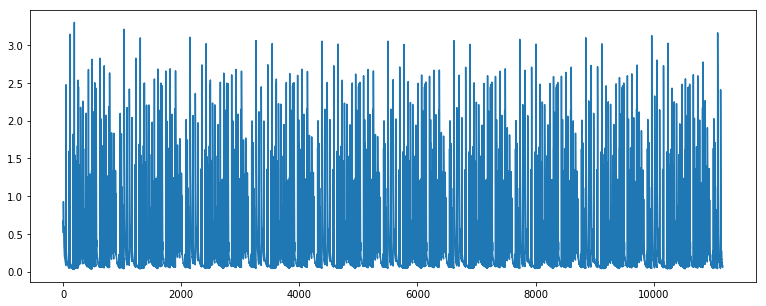

In [174]:
#losses
plt.figure(figsize=(13,5))
sns.lineplot(x=range(len(losses)),y=losses)

In [17]:
# Test
total = 0
correct = 0
with torch.no_grad():
    for i, (raw_kmer, raw_labels) in enumerate(test):
        kmer = prepareSequence(raw_kmer, kmers_dict)
        labels = torch.tensor(raw_labels)
        out = basicLSTM(labels)
        _, predicted = torch.max(out, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    

In [18]:
# This is a bad result given that roughly 75% of the test set are 0's ... it means it gets all the ones wrong
correct/total

0.556365202411714

In [19]:
# Number of '1's in the test set
sum([item for sublist in (b for a,b in test) for item in sublist])/len([item for sublist in (b for a,b in test) for item in sublist])

0.44363479758828595

In [146]:
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
classes = {0: 'inter-genic', 1: 'genic'}

with torch.no_grad():
    for i, (raw_kmer, raw_labels) in enumerate(test):
        kmer = prepareSequence(raw_kmer, kmers_dict)
        labels = torch.tensor(raw_labels)
        out = basicLSTM(labels)
        _, predicted = torch.max(out, 1)
        c = (predicted == labels).squeeze()
        for i in range(1):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(2):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of inter-genic : 100 %
Accuracy of genic :  0 %


In [145]:
?torch.Tensor.squeeze

Docstring:
squeeze(dim=None) -> Tensor

See :func:`torch.squeeze`
Type:      method_descriptor
